# Import Relevant Libraries

In [1]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
import statistics
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn import metrics
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
#from deap.tools import Statistics
import seaborn as sns 
sns.set() 
from sklearn.cluster import KMeans 
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt 
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from numpy import unique

# Read by default 1st sheet of an excel file

In [2]:
data = pd.read_excel('D:/Retail/Online Retail1.xlsx')
print('\n Dimension of Data is : ')
print(data.shape)


 Dimension of Data is : 
(541909, 8)


#  Data Cleaning
## Check for Missing Values

In [3]:
print('\n Missing data : ')
print(data.isnull().sum())


 Missing data : 
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


## 1. Removing Records having Blank values in CustomerID 

In [4]:
data['CustomerID'].replace('', np.nan, inplace=True)
data.dropna(subset=['CustomerID'], inplace=True)
print('\n Dimension of Data is : ')
print(data.shape)



 Dimension of Data is : 
(406829, 8)


## 2. Removing Records having Quantity Negative 

In [5]:
data = data[data['Quantity'] > 0]
print('\n Dimension of Data is : ')
print(data.shape)
print(data['InvoiceNo'].nunique())


 Dimension of Data is : 
(397924, 8)
18536


## 3. Drop Duplicate Records

In [6]:
data.drop_duplicates()
#print("\n Size of Data Frame after cleaning = {}".format(shape))
print(data.shape)

(397924, 8)


# Displaying the Cleaned top five records of Dataframe

In [7]:
data['TotalPrice']=data['Quantity']*data['UnitPrice']
print(data.head(5))

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom       20.34  


In [8]:
df = data.groupby(['InvoiceNo'])['InvoiceNo'].count().reset_index(name='InvoiceCounts')
df1 = data.groupby(['InvoiceNo'])['TotalPrice'].sum().reset_index(name='InvoicePrice')
df=df.join(df1['InvoicePrice'])
print(df.head(5)) 

   InvoiceNo  InvoiceCounts  InvoicePrice
0     536365              7        139.12
1     536366              2         22.20
2     536367             12        278.73
3     536368              4         70.05
4     536369              1         17.85


# View the statistical summary of numerical variables

In [9]:
print('Summary Statistics is :')
df[['InvoiceCounts','InvoicePrice']].describe()

Summary Statistics is :


,InvoiceCounts,InvoicePrice
count,18536.000000,18536.000000
mean,21.467631,480.762187
std,24.919243,1678.029352
min,1.000000,0.000000
25%,6.000000,157.930000
50%,15.000000,303.020000
75%,28.000000,471.660000
max,542.000000,168469.600000


# RFM Analysis
## Calculating Recency

In [10]:
data_recency = data.groupby(by='CustomerID',
                        as_index=False)['InvoiceDate'].max()
data_recency.columns = ['CustomerID', 'LastInvoiceDate']
recent_date = data_recency['LastInvoiceDate'].max()
data_recency['Recency'] = data_recency['LastInvoiceDate'].apply(
    lambda x: (recent_date - x).days)
print(data_recency.head(5))

   CustomerID     LastInvoiceDate  Recency
0     12346.0 2011-01-18 10:01:00      325
1     12347.0 2011-12-07 15:52:00        1
2     12348.0 2011-09-25 13:13:00       74
3     12349.0 2011-11-21 09:51:00       18
4     12350.0 2011-02-02 16:01:00      309


## Calculating Frequency

In [11]:
frequency_data = data.drop_duplicates().groupby(
    by=['CustomerID'], as_index=False)['InvoiceDate'].count()
frequency_data.columns = ['CustomerID', 'Frequency']
frequency_data.head(5)

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


## Calculating Monetary Value

In [12]:
data['Total'] = data['UnitPrice']*data['Quantity']
monetary_data = data.groupby(by='CustomerID', as_index=False)['Total'].sum()
monetary_data.columns = ['CustomerID', 'Monetary']
monetary_data.head(5)

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


# Merging RFM

In [13]:
rf_data = data_recency.merge(frequency_data, on='CustomerID')
rfm_data = rf_data.merge(monetary_data, on='CustomerID').drop(
    columns='LastInvoiceDate')
rfm_data.head(5)

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


# Ranking Customer’s based upon their RFM score

In [14]:
rfm_data['R_rank'] = rfm_data['Recency'].rank(ascending=False)
rfm_data['F_rank'] = rfm_data['Frequency'].rank(ascending=True)
rfm_data['M_rank'] = rfm_data['Monetary'].rank(ascending=True)
 
# normalizing the rank of the customers
rfm_data['R_rank_norm'] = (rfm_data['R_rank']/rfm_data['R_rank'].max())*100
rfm_data['F_rank_norm'] = (rfm_data['F_rank']/rfm_data['F_rank'].max())*100
rfm_data['M_rank_norm'] = (rfm_data['F_rank']/rfm_data['M_rank'].max())*100
 
rfm_data.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
rfm_data.head(5)

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,12346.0,325,1,77183.60,3.750291,0.841208,0.841208
1,12347.0,1,182,4310.00,97.915211,88.234616,88.234616
2,12348.0,74,31,1797.24,38.504542,42.359991,42.359991
3,12349.0,18,73,1757.55,74.120662,67.100714,67.100714
4,12350.0,309,17,334.40,5.369206,24.959668,24.959668


# Calculating RFM score

In [15]:
rfm_data['RFM_Score'] = 0.15*rfm_data['R_rank_norm']+0.28 * \
    rfm_data['F_rank_norm']+0.57*rfm_data['M_rank_norm']
rfm_data['RFM_Score'] *= 0.05
rfm_data = rfm_data.round(2)
rfm_data[['CustomerID', 'RFM_Score']].head(5)

,CustomerID,RFM_Score
0,12346.0,0.06
1,12347.0,4.48
2,12348.0,2.09
3,12349.0,3.41
4,12350.0,1.10


# Rating Customer based upon the RFM score
   ## rfm score >4.5 : Top Customer
   ## 4.5 > rfm score > 4 : High Value Customer
   ## 4>rfm score >3 : Medium value customer
   ## 3>rfm score>1.6 : Low-value customer
   ## rfm score<1.6 :Lost Customer

In [16]:
rfm_data["Customer_segment"] = np.where(rfm_data['RFM_Score'] >
                                      4.5, "Top Customers",
                                      (np.where(
                                        rfm_data['RFM_Score'] > 4,
                                        "High value Customer",
                                        (np.where(
    rfm_data['RFM_Score'] > 3,
                             "Medium Value Customer",
                             np.where(rfm_data['RFM_Score'] > 1.6,
                            'Low Value Customers', 'Lost Customers'))))))
rfm_data['CustomerID'] = rfm_data['CustomerID'].astype(int)
rfm_data[['CustomerID', 'RFM_Score', 'Customer_segment']].head(20)


,CustomerID,RFM_Score,Customer_segment
0,12346,0.06,Lost Customers
1,12347,4.48,High value Customer
2,12348,2.09,Low Value Customers
3,12349,3.41,Medium Value Customer
4,12350,1.10,Lost Customers
5,12352,3.46,Medium Value Customer
6,12353,0.33,Lost Customers
7,12354,2.67,Low Value Customers
8,12355,0.93,Lost Customers
9,12356,3.11,Medium Value Customer


# Visualizing the customer segments

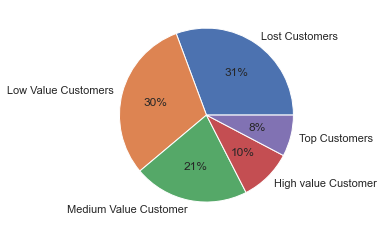

In [17]:
plt.pie(rfm_data.Customer_segment.value_counts(),
        labels=rfm_data.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

# Declare feature vector and target variable

In [18]:
X = df['InvoiceCounts']
y= df['InvoicePrice']

# Split the data Train and Test

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = 0.80)

# Plot of Train Data

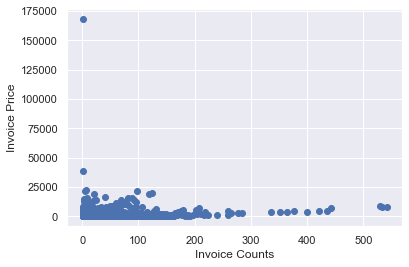

In [20]:
plt.scatter(X_train, y_train)
plt.xlabel('Invoice Counts')
plt.ylabel('Invoice Price')
plt.show()

# Plot of Test Data

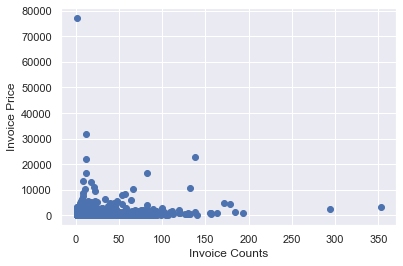

In [21]:
plt.scatter(X_test, y_test)
plt.xlabel('Invoice Counts')
plt.ylabel('Invoice Price')
plt.show()

# Elbow method to visualize the intertia

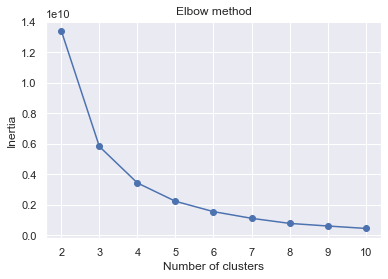

In [22]:
data_train = list(zip(X_train, y_train))
data_test = list(zip(X_test, y_test))
inertias = []

for i in range(2,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data_train)
    inertias.append(kmeans.inertia_)

plt.plot(range(2,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# K-Means model with three clusters

In [23]:
## lets apply min-max scaling to each row
# define our scaler
scaler = MinMaxScaler()

# scale down our data
data_scaled_train = scaler.fit_transform(data_train)
data_scaled_test = scaler.fit_transform(data_test)

# see here four rows that are scaled
print( data_scaled_train[0:4])
print(data_scaled_test[0:4])

[[0.04066543 0.00250757]
 [0.10536044 0.0014072 ]
 [0.01663586 0.00106096]
 [0.04251386 0.02142701]]
[[0.03977273 0.00475408]
 [0.         0.00287307]
 [0.         0.0033579 ]
 [0.         0.00091278]]



 kmeans.cluster_centers are :
[[0.08647177 0.00406781]
 [0.02033997 0.00234874]
 [0.25663054 0.00952894]]

 kmeans.intertia is :
11.129182715514924


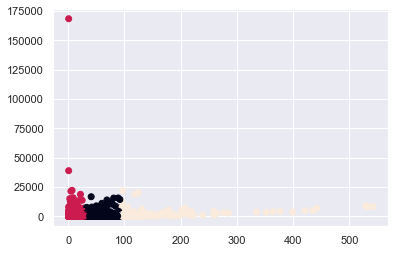

In [24]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(data_scaled_train)
print('\n kmeans.cluster_centers are :')
print(kmeans.cluster_centers_)
print('\n kmeans.intertia is :')
print(kmeans.inertia_)
plt.scatter(X_train, y_train, c=kmeans.labels_)
plt.show()

# Checking quality of classification by the K-Means model 

In [25]:
labels = kmeans.labels_
# check how many of the samples were correctly labeled
correct_labels = sum(labels)
print("\n Result: %d out of %d samples are correctly labeled." % (correct_labels, y.size))
print('\n Accuracy score due to K-Means Model: {0:0.2f}'. format(correct_labels/float(y.size)))


 Result: 12002 out of 18536 samples are correctly labeled.

 Accuracy score due to K-Means Model: 0.65


# Evaluating performance of the clustering algorithm 
# using a Silhouette score

In [26]:
print('\n The Silhouette score for K-Means is : ')
from sklearn.metrics import silhouette_score
print(silhouette_score(data_scaled_train, kmeans.labels_, metric='euclidean'))


 The Silhouette score for K-Means is : 
0.6441100374247929


# Gaussian Mixture Model


In [27]:
# Standardize data
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(data_train) 
  
# Normalizing the Data 
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 
  
# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
  
X_principal.head(3)

,P1,P2
0,1.042940,-0.536971
1,1.271731,-0.113319
2,-0.672674,-0.081712


In [28]:
gmm = GaussianMixture(n_components=3)
#gmm.fit(X_principal)
gmm.fit(scaled_df)

GaussianMixture(n_components=3)

# Visualizing the clustering of  GaussianMixture

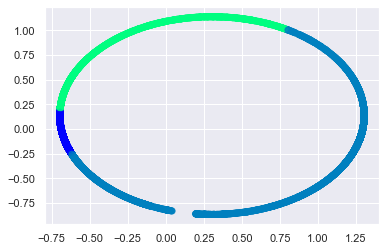

In [29]:
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = GaussianMixture(n_components = 3).fit_predict(X_principal), cmap =plt.cm.winter, alpha = 0.6) 
plt.show() 

# # Checking quality of classification by the Gaussian Mixture model 

In [30]:
labels = gmm.predict(scaled_df)
correct_labels = sum(labels)
print("Result: %d out of %d samples are correctly labeled." % (correct_labels, y.size))
print('\n Accuracy score due to Gaussian Mixture Model: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 4497 out of 18536 samples are correctly labeled.

 Accuracy score due to Gaussian Mixture Model: 0.24


# DBSCAN Clustering Model (Distribution Based)
## create a ‘Cluster’ column

In [31]:
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
data_train, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=0)
X = StandardScaler().fit_transform(data_train)

# Computing DB_SCAN

In [32]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.

In [33]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Evaluation of DB_SCAN
## Silhouette Coefficient score of more than 0.5 indicating that my model # doesn’t have 
## overlapping clusters or mislabeled data points.

In [34]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


# Visualizing the clustering

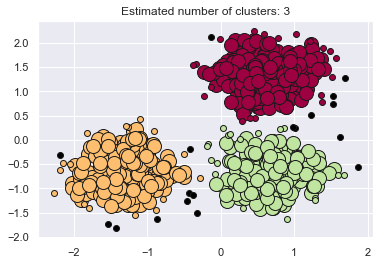

In [35]:
# Plot result
import matplotlib.pyplot as plt
%matplotlib inline

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


# Hierarchical Clustering
# Dendogram Construction

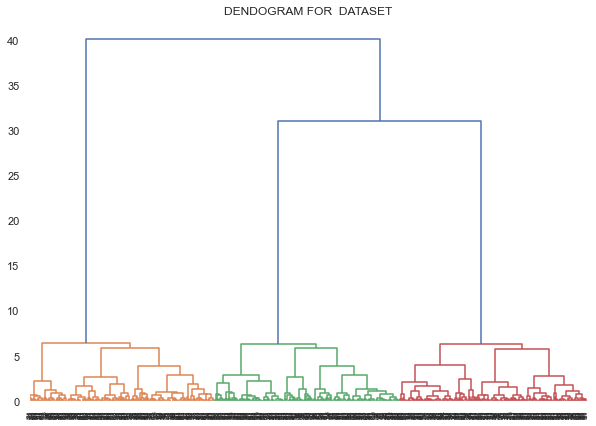

In [36]:
plt.figure(figsize=(10, 7))
plt.title("DENDOGRAM FOR  DATASET")
dendo_gram = shc.dendrogram(shc.linkage(X, method = "ward"))

# Agglomerative Clustering

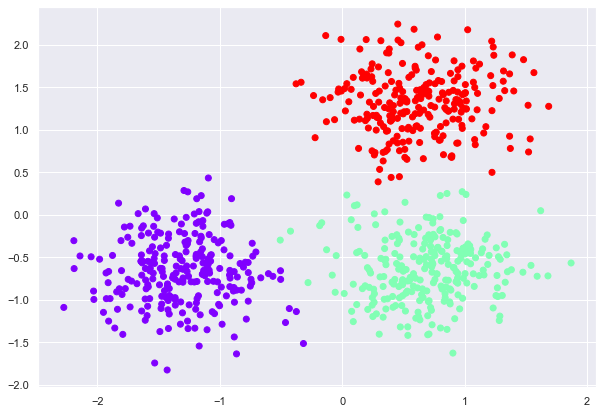

In [37]:
cluster = AgglomerativeClustering(n_clusters = 3, affinity = "euclidean", linkage = "ward")
cluster.fit_predict(X)
#Visualising the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=cluster.labels_, cmap='rainbow')

# Computing Agglomerative Score

In [44]:
print('Agglomerative Score is :')
print(silhouette_score(X,cluster.labels_, metric='euclidean'))

Agglomerative Score is :
0.6477977039854915


# BIRCH Algorithm

Clusters of Birch [0 1 2]
Score of Birch =  0.6472104406200997


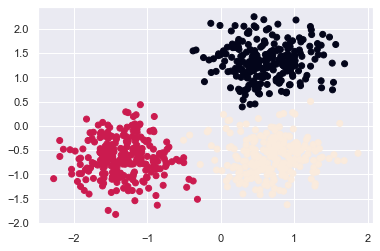

In [38]:
model_br = Birch(threshold=0.01, n_clusters=3)
model_br.fit(X)
yhat_br = model_br.predict(X)
clusters_br = unique(yhat_br)
print("Clusters of Birch",clusters_br)
labels_br = model_br.labels_
plt.scatter(X[:, 0], X[:, 1], c = yhat_br)
score_br = metrics.silhouette_score(X,labels_br)
print("Score of Birch = ", score_br)